Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
{'cat': 0, 'dog': 1}
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_6 (Rescaling)      (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 128, 128, 16)      448       
_________________________________________________________________
leaky_re_lu_42 (LeakyReLU)   (None, 128, 128, 16)      0         
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 64, 64, 32)        4640      
_________________________________________________________________
leaky_re_lu_43 (LeakyReLU)   (None, 64, 64, 32)        0         
_______________

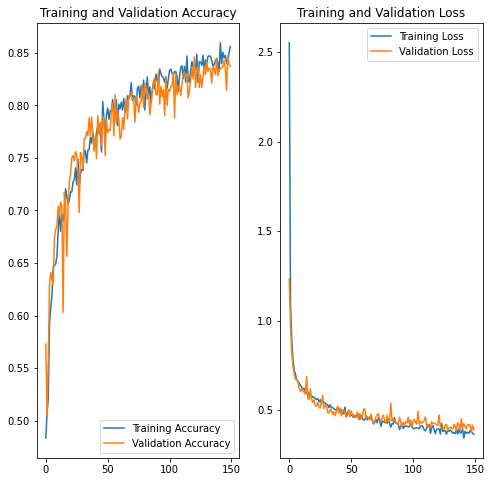

INFO:tensorflow:Assets written to: saved_model/assets


In [18]:
# DT069A Laboration 1
# This code will need tensorflow, matplotlib, and SciPy to be installed. Use pip to install them.

# Imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.python.keras.layers import Rescaling
import tensorflow as tf
import matplotlib.pyplot as plt

# EFH - Imports 
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Activation, LeakyReLU, Dropout, SpatialDropout2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Variables
train_dir = 'images/train'
validation_dir = 'images/validation'
total_train = 2000
total_val = 1000
IMG_SIZE = 128 #EFH - changed to a power of two, hoping for faster training, but smaller dimensions gives lower performance
batch_size = 32 #EFH - changed to smaller batch size than default 128, having better results
epochs = 150 #EFH - changed to larger number of epochs to train model longer

# EFH - Hyperparameters
leaky_alpha = 0.2 #EFH - alpha parameter for leakyRelu, hoping to avoid dying ReLU problem, but slowing down training
regHyper = 0.00001 #EFH - alpha for ridge regression, L2 regularization, current value found by trial and error

# EFH - ImageDataGenerator object for training data with image augmentation, to mitigate overfitting
train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.1,
    rotation_range=20,
    horizontal_flip=True,
    fill_mode='wrap')

# EFH - ImageDataGenerator object for validation data without image augmentation
val_datagen = ImageDataGenerator()

# EFH - Generate training dataset
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='binary',
    interpolation='lanczos')

# EFH - Generate validation dataset
validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='binary',
    interpolation='lanczos')
    
# EFH - Print class names
print(train_generator.class_indices)

# EFH - Define the model - building on default model with additional layers, same structure. Larger number of
#Filters in first layer possible, but slows down performance, a lot, not possible to test all options.
#Kernel_initializer changed to he_uniform, which I read performs well with ReLU and variants.
#Activation changed to LeakyRelu, regularization added, using ridge regression on the layers output.
#SpatialDropout2D drops entire 2D feature maps, which could be useful when adjancent pixels are correlated, 
#and can be placed before poolinglayer. Perhaps normal Dropout could be used in later layers instead, 
#neither dropout seems to perform well on first group of layers and have been left out. Normal Dropout used
#between Dense layers. Was not able to get any positive impact using BatchNormalization.
#GlobalAverage2D pooling was tested instead of the Dense layers and Flattening, but did not work as well here.

model = Sequential([
    Rescaling(1./255, input_shape=(IMG_SIZE, IMG_SIZE, 3)),

    Conv2D(16, 3, padding='same', kernel_initializer=('he_uniform')),
    LeakyReLU(leaky_alpha, activity_regularizer=l2(regHyper)),
    MaxPooling2D(),

    Conv2D(32, 3, padding='same', kernel_initializer=('he_uniform')),
    LeakyReLU(leaky_alpha, activity_regularizer=l2(regHyper)),
    SpatialDropout2D(0.4),
    MaxPooling2D(),

    Conv2D(64, 3, padding='same', kernel_initializer=('he_uniform')),
    LeakyReLU(leaky_alpha, activity_regularizer=l2(regHyper)),
    SpatialDropout2D(0.4),
    MaxPooling2D(),

    Conv2D(128, 3, padding='same', kernel_initializer=('he_uniform')),
    LeakyReLU(leaky_alpha, activity_regularizer=l2(regHyper)),
    SpatialDropout2D(0.4),
    MaxPooling2D(),

    Conv2D(256, 3, padding='same', kernel_initializer=('he_uniform')),
    LeakyReLU(leaky_alpha, activity_regularizer=l2(regHyper)),
    SpatialDropout2D(0.4),
    MaxPooling2D(),

    Conv2D(512, 3, padding='same', kernel_initializer=('he_uniform')),
    LeakyReLU(leaky_alpha, activity_regularizer=l2(regHyper)),
    SpatialDropout2D(0.4),
    MaxPooling2D(),

    Flatten(),
    Dense(512),
    LeakyReLU(leaky_alpha, activity_regularizer=l2(regHyper)),
    Dropout(0.2),
    Dense(2)
])

# Compile the model
model.compile(optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

# Print a summary of the whole model
model.summary()

# EFH - Train the model and validate - using datasets from data generators
history = model.fit(
  train_generator,
  validation_data=validation_generator,
  epochs=epochs
)

# Visualize the accuracy and loss plots
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Save the trained model for later
model.save('saved_model')

In [19]:
# DT069A Laboration 1
# This code will need tensorflow, and numpy to be installed. Use pip to install them.

# Imports
import tensorflow as tf
import numpy as np

# Load our pre trained model
model = tf.keras.models.load_model('saved_model')

# Load single image
test_image = tf.keras.preprocessing.image.load_img('images/mypet3.jpg', target_size=(128, 128))
test_array = tf.keras.preprocessing.image.img_to_array(test_image)
test_array = np.array([test_array])

# Predict using model
prediction = model.predict(test_array)

# Interpret the results
print ("Test image evaluation: ", prediction)
if prediction[0][0] > prediction[0][1]:
    print ("Test image is of category: cat")
else:
    print ("Test image is of category: dog")



Test image evaluation:  [[-4.016688  4.486666]]
Test image is of category: dog
